# **Project Title: Generate AI Fashion Models Wearing Your Clothes**

**Project Description:**
This project leverages Stable Diffusion model and various CV techniques to generate high-quality images of fashion models wearing user-inputted clothes (upper body clothes only) and faces. The process involves three key steps. The project aims to showcase the capabilities of AI in personalized fashion model generation, highlighting the seamless integration of clothing and facial features through state-of-the-art diffusion models.

**Proposed solution**:

* Cloth segmentation: Use a segmentation model to detect and segment clothing from user-uploaded photos isolating the clothing item from the background without detailing various body types or complex poses.

* Face segmentation: Use a segmentation model to detect and crop Face from user-uploaded photos to avoid model poses and other noise impact generated image.

* Image Synthesis and Cloth intergration: Encode segmented clothing and cropped face and text-prompt (to generate human model) and feed them to a pre-trained Stable Diffusion model to generate initial model image with fitted clothes. 

* Faceswap and detailer: Using face-swap and face-detailer process to help the generated image face look closer to user-inputed face

**Technology and Techniques:** 
The core of my application will utilize ComfyUI to intergrate various models to generate the required image


In [1]:
import os
import random
import sys
from typing import Sequence, Mapping, Any, Union
import torch
import numpy as np
from PIL import Image

sys.argv = ['virtal_try_on.ipynb']

In [2]:
def get_value_at_index(obj: Union[Sequence, Mapping], index: int) -> Any:
    """Returns the value at the given index of a sequence or mapping.

    If the object is a sequence (like list or string), returns the value at the given index.
    If the object is a mapping (like a dictionary), returns the value at the index-th key.

    Some return a dictionary, in these cases, we look for the "results" key

    Args:
        obj (Union[Sequence, Mapping]): The object to retrieve the value from.
        index (int): The index of the value to retrieve.

    Returns:
        Any: The value at the given index.

    Raises:
        IndexError: If the index is out of bounds for the object and the object is not a mapping.
    """
    try:
        return obj[index]
    except KeyError:
        return obj["result"][index]


def find_path(name: str, path: str = None) -> str:
    """
    Recursively looks at parent folders starting from the given path until it finds the given name.
    Returns the path as a Path object if found, or None otherwise.
    """
    # If no path is given, use the current working directory
    if path is None:
        path = os.getcwd()

    # Check if the current directory contains the name
    if name in os.listdir(path):
        path_name = os.path.join(path, name)
        print(f"{name} found: {path_name}")
        return path_name

    # Get the parent directory
    parent_directory = os.path.dirname(path)

    # If the parent directory is the same as the current directory, we've reached the root and stop the search
    if parent_directory == path:
        return None

    # Recursively call the function with the parent directory
    return find_path(name, parent_directory)

def add_comfyui_directory_to_sys_path() -> None:
    """
    Add 'ComfyUI' to the sys.path
    """
    comfyui_path = find_path("ComfyUI")
    if comfyui_path is not None and os.path.isdir(comfyui_path):
        sys.path.append(comfyui_path)
        print(f"'{comfyui_path}' added to sys.path")

def add_extra_model_paths() -> None:
    """
    Parse the optional extra_model_paths.yaml file and add the parsed paths to the sys.path.
    """
    from main import load_extra_path_config

    extra_model_paths = find_path("extra_model_paths.yaml")

    if extra_model_paths is not None:
        load_extra_path_config(extra_model_paths)
    else:
        print("Could not find the extra_model_paths config file.")

add_comfyui_directory_to_sys_path()
add_extra_model_paths()

def import_custom_nodes() -> None:
    """Find all custom nodes in the custom_nodes folder and add those node objects to NODE_CLASS_MAPPINGS

    This function sets up a new asyncio event loop, initializes the PromptServer,
    creates a PromptQueue, and initializes the custom nodes.
    """
    import asyncio
    import execution
    from nodes import init_custom_nodes
    import server

    # Creating a new event loop and setting it as the default loop
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

    # Creating an instance of PromptServer with the loop
    server_instance = server.PromptServer(loop)
    execution.PromptQueue(server_instance)

    # Initializing custom nodes
    init_custom_nodes()


ComfyUI found: c:\Users\hoanghuy.nguyen\ComfyUI
'c:\Users\hoanghuy.nguyen\ComfyUI' added to sys.path
## ComfyUI-Manager: installing dependencies done.
** ComfyUI startup time: 2024-05-18 16:29:36.514167
** Platform: Windows
** Python version: 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]
** Python executable: c:\Users\hoanghuy.nguyen\ComfyUI\venv\Scripts\python.exe
** Log path: c:\Users\hoanghuy.nguyen\ComfyUI\notebooks\comfyui.log

Prestartup times for custom nodes:
   0.2 seconds: C:\Users\hoanghuy.nguyen\ComfyUI\custom_nodes\ComfyUI-Manager



Total VRAM 23028 MB, total RAM 130780 MB
Set vram state to: NORMAL_VRAM
Device: cuda:0 NVIDIA GeForce RTX 4090 : native
VAE dtype: torch.bfloat16
c:\Users\hoanghuy.nguyen\ComfyUI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using pytorch cross attention


Could not find the extra_model_paths config file.


In [3]:
#Define function to return image from tensor
def tensor_to_image(image_tensor):
    tensor = image_tensor.squeeze(0)
    np_array = tensor.numpy()
    np_array = np_array * 255
    np_array = np_array.astype(np.uint8)
    pil_image = Image.fromarray(np_array)
    return pil_image

In [4]:
from nodes import LoadImage, NODE_CLASS_MAPPINGS
import_custom_nodes()
loadimage = LoadImage()
efficient_loader = NODE_CLASS_MAPPINGS["Efficient Loader"]()
samloader = NODE_CLASS_MAPPINGS["SAMLoader"]()
ultralyticsdetectorprovider = NODE_CLASS_MAPPINGS["UltralyticsDetectorProvider"]()
cropface = NODE_CLASS_MAPPINGS["CropFace"]()
magicclothing_generate = NODE_CLASS_MAPPINGS["MagicClothing_Generate"]()
reactorfaceswap = NODE_CLASS_MAPPINGS["ReActorFaceSwap"]()
ipadapterunifiedloaderfaceid = NODE_CLASS_MAPPINGS["IPAdapterUnifiedLoaderFaceID"]()
ipadapterfaceid = NODE_CLASS_MAPPINGS["IPAdapterFaceID"]()
ipadapterunifiedloader = NODE_CLASS_MAPPINGS["IPAdapterUnifiedLoader"]()
ipadapter = NODE_CLASS_MAPPINGS["IPAdapter"]()
facedetailer = NODE_CLASS_MAPPINGS["FaceDetailer"]()

### Loading: ComfyUI-Impact-Pack (V4.90.1)
### Loading: ComfyUI-Impact-Pack (Subpack: V0.4)


[Impact Pack] Wildcards loading done.
[ComfyUI-Manager] default cache updated: https://raw.githubusercontent.com/ltdrdata/ComfyUI-Manager/main/alter-list.json
[ComfyUI-Manager] default cache updated: https://raw.githubusercontent.com/ltdrdata/ComfyUI-Manager/main/model-list.json
[ComfyUI-Manager] default cache updated: https://raw.githubusercontent.com/ltdrdata/ComfyUI-Manager/main/extension-node-map.json
[ComfyUI-Manager] default cache updated: https://raw.githubusercontent.com/ltdrdata/ComfyUI-Manager/main/custom-node-list.json


c:\Users\hoanghuy.nguyen\ComfyUI\venv\Lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
c:\Users\hoanghuy.nguyen\ComfyUI\venv\Lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


### Loading: ComfyUI-Manager (V2.26)
### ComfyUI Revision: 2148 [10fcd09f] | Released on '2024-04-27'
[ReActor] - STATUS - Running v0.5.0-a1 in ComfyUI
Torch version: 2.3.0+cu121


[comfyui_controlnet_aux] | INFO -> Using ckpts path: C:\Users\hoanghuy.nguyen\ComfyUI\custom_nodes\comfyui_controlnet_aux\ckpts
[comfyui_controlnet_aux] | INFO -> Using symlinks: False
[comfyui_controlnet_aux] | INFO -> Using ort providers: ['CUDAExecutionProvider', 'DirectMLExecutionProvider', 'OpenVINOExecutionProvider', 'ROCMExecutionProvider', 'CPUExecutionProvider', 'CoreMLExecutionProvider']


FaceDetailer: Model directory already exists
FaceDetailer: Model already exists
Efficiency Nodes: Attempting to add Control Net options to the 'HiRes-Fix Script' Node (comfyui_controlnet_aux add-on)...Success!



Import times for custom nodes:
   0.0 seconds: C:\Users\hoanghuy.nguyen\ComfyUI\custom_nodes\websocket_image_save.py
   0.0 seconds: C:\Users\hoanghuy.nguyen\ComfyUI\custom_nodes\sdxl-recommended-res-calc
   0.0 seconds: C:\Users\hoanghuy.nguyen\ComfyUI\custom_nodes\ComfyUI_IPAdapter_plus
   0.0 seconds: C:\Users\hoanghuy.nguyen\ComfyUI\custom_nodes\ComfyMath
   0.0 seconds: C:\Users\hoanghuy.nguyen\ComfyUI\custom_nodes\ComfyUI_UltimateSDUpscale
   0.0 seconds: C:\Users\hoanghuy.nguyen\ComfyUI\custom_nodes\efficiency-nodes-comfyui
   0.0 seconds: C:\Users\hoanghuy.nguyen\ComfyUI\custom_nodes\ComfyUI_InstantID
   0.0 seconds: C:\Users\hoanghuy.nguyen\ComfyUI\custom_nodes\ComfyUI_MagicClothing
   0.0 seconds: C:\Users\hoanghuy.nguyen\ComfyUI\custom_nodes\comfyui_controlnet_aux
   0.0 seconds: C:\Users\hoanghuy.nguyen\ComfyUI\custom_nodes\facerestore_cf
   0.0 seconds: C:\Users\hoanghuy.nguyen\ComfyUI\custom_nodes\comfyui-reactor-node
   0.2 seconds: C:\Users\hoanghuy.nguyen\ComfyUI\cust

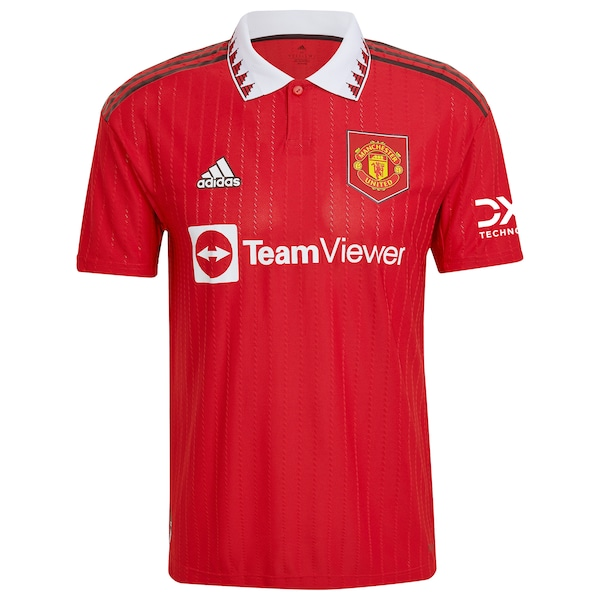

In [5]:
#Input cloth image and convert to tensor
cloth_image_input = loadimage.load_image(image="mu.jpg")
tensor_to_image(cloth_image_input[0])

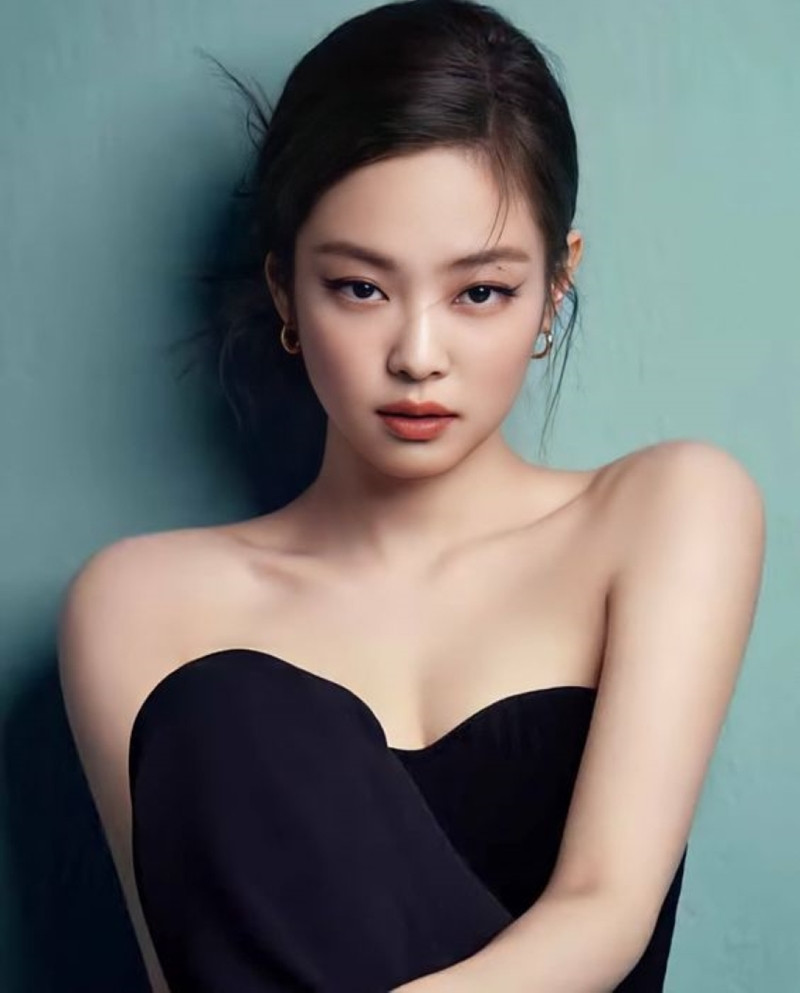

In [6]:
#Input face image and convert to tensor
face_image_input = loadimage.load_image(
    image="ket-cuc-lang-xet-cua-jennie-blackpink-khien-khan-gia-buon-nhung-ma-la-buon-cuoiwebp-100110 (5).jpg"
)
tensor_to_image(face_image_input[0])

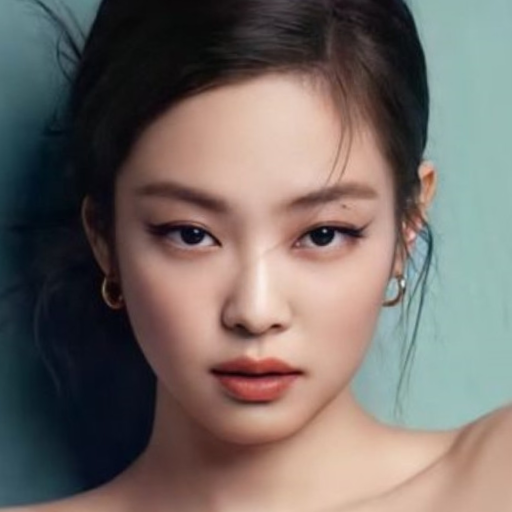

In [7]:
#Crop original face image to minimize non-face noise 
crop_face_image_input = cropface.crop_face(
    facedetection="retinaface_resnet50",
    image=get_value_at_index(face_image_input, 0),
)
tensor_to_image(crop_face_image_input[0])

In [8]:
# Initialize model body, face structure wearing inputed clothes 
tensor_image_with_input_cloth = magicclothing_generate.garment_generation(
    prompt="Create a realistic image of a female model standing front for a virtual try-on application. The model should be of average build, with medium-length straight brown hair and a neutral expression. She is wearing a red sport t-shirt and blue jeans. The background should be plain light grey to emphasize the outfit and minimize distractions. Importantly, the model’s hands should be placed behind her back to ensure a clean and unobstructed view of the clothing on the torso and legs. This positioning helps prevent rendering errors associated with the hands.",
    model_path="oms_diffusion_768_200000.safetensors",
    pipe_path="SG161222/Realistic_Vision_V5.1_noVAE",
    enable_cloth_guidance=True,
    num_samples=1,
    n_prompt="Avoid unrealistic body proportions and facial features that do not look natural. Exclude any distracting elements in the background like patterns, logos, or objects that could interfere with the focus on the clothing. Do not use bright or unnatural lighting that could alter the true colors of the clothing. Ensure the model does not have any visible tattoos, excessive makeup, or jewelry as these can distract from the clothing. Avoid dynamic poses; the model should not be in motion or displaying expressive poses that could complicate the clothing fitting",
    seed=random.randint(1, 2**64),
    scale=5,
    cloth_guidance_scale=3,
    sample_steps=20,
    height=768,
    width=576,
    faceid_version="FaceIDPlusV2",
    cloth_image=get_value_at_index(cloth_image_input, 0),
    face_image=get_value_at_index(crop_face_image_input, 0),
)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\hoanghuy.nguyen/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\hoanghuy.nguyen/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\hoanghuy.nguyen/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\hoanghuy.nguyen/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\hoanghuy.nguyen/.insightface\models\buffalo_l\w60

Token indices sequence length is longer than the specified maximum sequence length for this model (117 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['be placed behind her back to ensure a clean and unobstructed view of the clothing on the torso and legs. this positioning helps prevent rendering errors associated with the hands., best quality, high quality']
100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


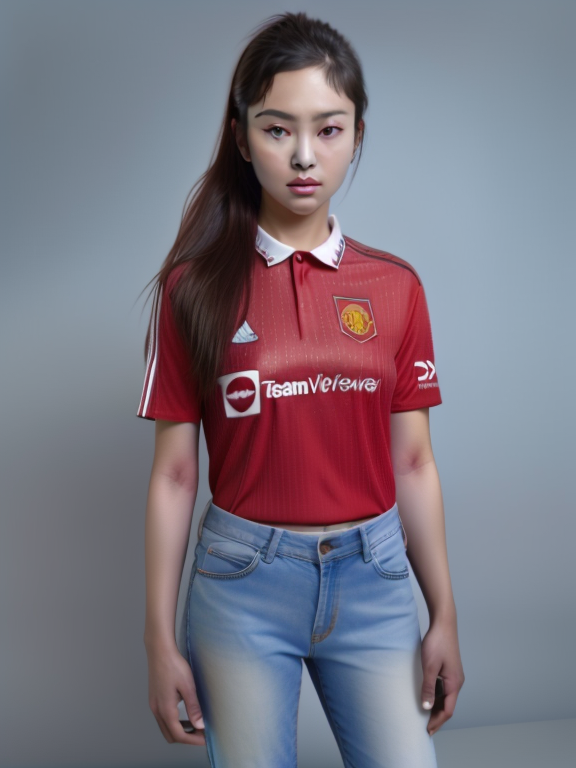

In [9]:
image_with_input_cloth = tensor_to_image(tensor_image_with_input_cloth[0])
image_with_input_cloth

In [10]:
# Do initial face-swap with inswapper_128 and face restore GFPGANv1.4 to merge your face into generated image
tensor_image_with_input_cloth_faceswaped = reactorfaceswap.execute(
    enabled=True,
    swap_model="inswapper_128.onnx",
    facedetection="retinaface_resnet50",
    face_restore_model="GFPGANv1.4.pth",
    face_restore_visibility=0.7000000000000001,
    codeformer_weight=0.5,
    detect_gender_input="no",
    detect_gender_source="no",
    input_faces_index="0",
    source_faces_index="0",
    console_log_level=1,
    input_image=get_value_at_index(tensor_image_with_input_cloth, 0),
    source_image=get_value_at_index(face_image_input, 0),
)

[ReActor] 16:30:10 - STATUS - Working: source face index [0], target face index [0]
[ReActor] 16:30:10 - STATUS - Analyzing Source Image...
[ReActor] 16:30:12 - STATUS - Analyzing Target Image...
[ReActor] 16:30:14 - STATUS - Swapping...
[ReActor] 16:30:14 - STATUS - --Done!--
[ReActor] 16:30:14 - STATUS - Restoring with GFPGANv1.4.pth


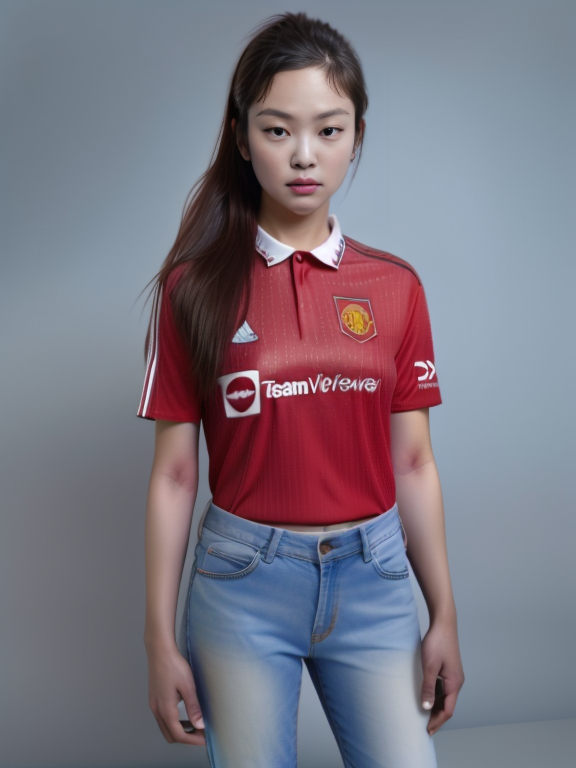

In [11]:
image_with_input_cloth_faceswaped = tensor_to_image(tensor_image_with_input_cloth_faceswaped[0])
image_with_input_cloth_faceswaped

In [12]:
# Face-detailer process with IP-Adapter FaceID to help the generated face look more realistic
with torch.inference_mode():
    #Load base model for face detailer
    efficient_loader_29 = efficient_loader.efficientloader(
        ckpt_name="realisticVisionV51_v51VAE.safetensors",
        vae_name="Baked VAE",
        clip_skip=-1,
        lora_name="None",
        lora_model_strength=1,
        lora_clip_strength=1,
        positive="CLIP_POSITIVE",
        negative="CLIP_NEGATIVE",
        token_normalization="none",
        weight_interpretation="comfy",
        empty_latent_width=576,
        empty_latent_height=768,
        batch_size=1,
    )
    
    #Applied IP-Adapter FaceID on base Model
    ipadapterunifiedloaderfaceid_42 = ipadapterunifiedloaderfaceid.load_models(
        preset="FACEID PLUS V2",
        lora_strength=0.6,
        provider="CPU",
        model=get_value_at_index(efficient_loader_29, 0),
    )

    ipadapterfaceid_46 = ipadapterfaceid.apply_ipadapter(
        weight=1,
        weight_faceidv2=1,
        weight_type="linear",
        combine_embeds="concat",
        start_at=0,
        end_at=1,
        embeds_scaling="V only",
        model=get_value_at_index(ipadapterunifiedloaderfaceid_42, 0),
        ipadapter=get_value_at_index(ipadapterunifiedloaderfaceid_42, 1),
        image=get_value_at_index(face_image_input, 0),
    )

    ipadapterunifiedloader_44 = ipadapterunifiedloader.load_models(
        preset="PLUS (high strength)",
        model=get_value_at_index(ipadapterfaceid_46, 0),
        ipadapter=get_value_at_index(ipadapterunifiedloaderfaceid_42, 1),
    )

    ipadapter_45 = ipadapter.apply_ipadapter(
        weight=1,
        start_at=0,
        end_at=1,
        weight_type="standard",
        model=get_value_at_index(ipadapterunifiedloader_44, 0),
        ipadapter=get_value_at_index(ipadapterunifiedloader_44, 1),
        image=get_value_at_index(ipadapterfaceid_46, 1),
    )

    # Load SAM for face-detailer process
    samloader_32 = samloader.load_model(
        model_name="sam_vit_h_4b8939.pth", device_mode="AUTO"
    )

    # Load bbox-detector for face-detailer process
    ultralyticsdetectorprovider_38 = ultralyticsdetectorprovider.doit(
        model_name="bbox/face_yolov8m.pt"
    )
    
    # Face-detailer process
    tensor_image_with_input_cloth_faceswaped_facedetailed = facedetailer.doit(
        guide_size=512,
        guide_size_for=True,
        max_size=1024,
        seed=random.randint(1, 2**64),
        steps=20,
        cfg=8,
        sampler_name="dpmpp_2m",
        scheduler="karras",
        denoise=0.2,
        feather=5,
        noise_mask=True,
        force_inpaint=True,
        bbox_threshold=0.5,
        bbox_dilation=10,
        bbox_crop_factor=3,
        sam_detection_hint="center-1",
        sam_dilation=0,
        sam_threshold=0.93,
        sam_bbox_expansion=0,
        sam_mask_hint_threshold=0.7,
        sam_mask_hint_use_negative="False",
        drop_size=10,
        wildcard="",
        cycle=1,
        inpaint_model=False,
        noise_mask_feather=20,
        image=get_value_at_index(tensor_image_with_input_cloth_faceswaped, 0),
        model=get_value_at_index(ipadapter_45, 0),
        clip=get_value_at_index(efficient_loader_29, 5),
        vae=get_value_at_index(efficient_loader_29, 4),
        positive=get_value_at_index(efficient_loader_29, 1),
        negative=get_value_at_index(efficient_loader_29, 2),
        bbox_detector=get_value_at_index(ultralyticsdetectorprovider_38, 0),
        sam_model_opt=get_value_at_index(samloader_32, 0),
    )

model_type EPS
Using pytorch attention in VAE
Using pytorch attention in VAE
clip missing: ['clip_l.logit_scale', 'clip_l.transformer.text_projection.weight']
Requested to load SD1ClipModel
Loading 1 new model


----------------------------------------
Global Models Cache:
Ckpt:
  [1] realisticVisionV51_v51VAE (ids: None)
INFO: Clip Vision model loaded from C:\Users\hoanghuy.nguyen\ComfyUI\models\clip_vision\CLIP-ViT-H-14-laion2B-s32B-b79K.safetensors
INFO: IPAdapter model loaded from C:\Users\hoanghuy.nguyen\ComfyUI\models\ipadapter\ip-adapter-faceid-plusv2_sd15.bin
INFO: LoRA model loaded from C:\Users\hoanghuy.nguyen\ComfyUI\models\loras\ip-adapter-faceid-plusv2_sd15_lora.safetensors
INFO: InsightFace model loaded with CPU provider
INFO: the IPAdapter reference image is not a square, CLIPImageProcessor will resize and crop it at the center. If the main focus of the picture is not in the middle the result might not be what you are expecting.


Requested to load CLIPVisionModelProjection
Loading 1 new model


INFO: IPAdapter model loaded from C:\Users\hoanghuy.nguyen\ComfyUI\models\ipadapter\ip-adapter-plus_sd15.safetensors
Loads SAM model: C:\Users\hoanghuy.nguyen\ComfyUI\models\sams\sam_vit_h_4b8939.pth (device:AUTO)

0: 640x480 1 face, 76.0ms
Speed: 0.0ms preprocess, 76.0ms inference, 10.3ms postprocess per image at shape (1, 3, 640, 480)
Detailer: segment upscale for ((107.98651, 148.62866)) | crop region (323, 445) x 2.3020981053899474 -> (743, 1024)


Requested to load AutoencoderKL
Loading 1 new model
Requested to load BaseModel
Loading 1 new model
100%|██████████| 20/20 [00:01<00:00, 11.62it/s]


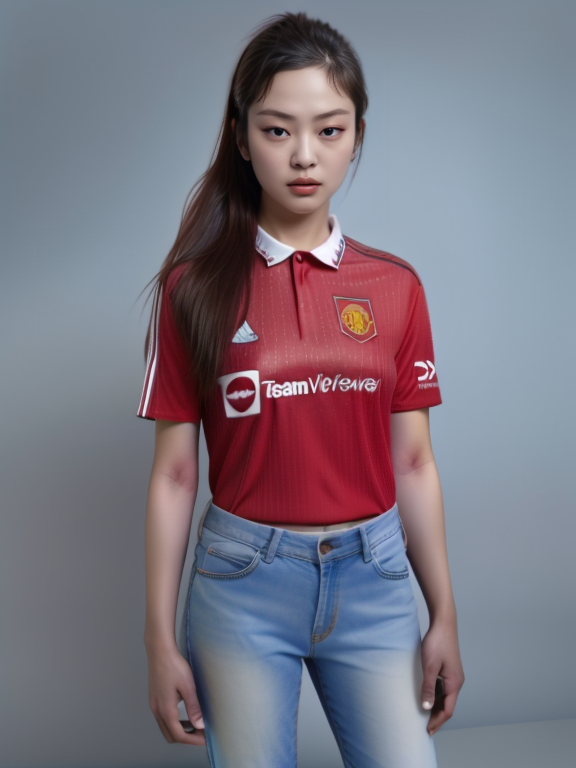

In [13]:
image_with_input_cloth_faceswaped_facedetailed = tensor_to_image(tensor_image_with_input_cloth_faceswaped_facedetailed[0])
image_with_input_cloth_faceswaped_facedetailed